In [2]:
%load_ext autoreload
%autoreload 2   

In [3]:
import numpy as np
from scipy.sparse.linalg import cg, lsqr, gmres
import matplotlib.pyplot as plt
import matplotlib.tri
import okada_wrapper
import tectosaur as tct

In [81]:
TCTN = 241
CURVE = 1.0

corners = [[-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, 0, 1]]
src_mesh = tct.make_rect(TCTN, TCTN, corners)
src_mesh[0][:,1] = CURVE * np.abs(src_mesh[0][:,0])
#src_mesh[0][:,1] = CURVE * (src_mesh[0][:,0] ** 2 + src_mesh[0][:,2] ** 2)
def gauss_slip_fnc(x, z):
    r2 = x ** 2 + z ** 2
    R = 0.8
    out = (np.cos(np.sqrt(r2) * np.pi / R) + 1) / 2.0
    out[np.sqrt(r2) > R] = 0.0
    return out
dof_pts = src_mesh[0][src_mesh[1]]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((src_mesh[1].shape[0], 3, 3)).astype(np.float32)
slip[:,:,0] = gauss_slip_fnc(x, z)

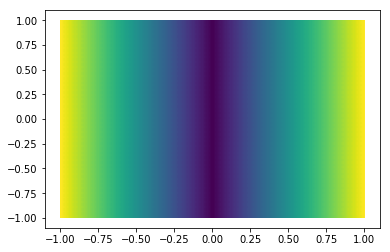

In [82]:
plt.tripcolor(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1], src_mesh[0][:,1])
plt.show()

In [83]:
H = tct.RegularizedSparseIntegralOp(
    6, 6, 6, 2, 5, 2.5,
    'elasticRH3', 'elasticRH3', [1.0, 0.25], src_mesh[0], src_mesh[1], np.float32,
    farfield_op_type = tct.TriToTriDirectFarfieldOp
)
traction_mass_op = tct.MassOp(4, src_mesh[0], src_mesh[1])

[996301:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[996308:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[996311:DEBUG:tectosaur.nearfield.nearfield_op]
         setup pairs integrator took 0.010427691042423248
[1009478:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident took 13.166097939014435
[1009527:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident correction took 0.04656554386019707
[1012626:DEBUG:tectosaur.nearfield.nearfield_op]
         Find nearfield/adjacency took 3.0983836762607098
[1014241:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent took 1.6140199340879917
[1014401:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent correction took 0.15962997823953629
[1016635:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent took 2.2319175451993942
[1017039:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent correction took 0.40018076822161674
[1021984:DEBUG:tectosaur.

In [110]:
dof_pts = src_mesh[0][src_mesh[1]]
from tectosaur.util.geometry import unscaled_normals
ns = unscaled_normals(dof_pts)
ns /= np.linalg.norm(ns, axis = 1)[:, np.newaxis]
ns = np.repeat(ns, 3, axis = 0)

edge_dofs = tct.free_edge_dofs(src_mesh[1], tct.find_free_edges(src_mesh[1]))

obs_pts = dof_pts.reshape((-1,3))[edge_dofs]
obs_ns = ns[edge_dofs]
interior_op = tct.InteriorOp(obs_pts.copy(), obs_ns.copy(), src_mesh, 'elasticH3', 4.0, 11, 7, 7, [1.0, 0.25], np.float32)

trac_edges = -interior_op.dot(slip.flatten())

vec_edge_dofs = np.tile(3 * np.array(edge_dofs)[:,np.newaxis], (1,3))
vec_edge_dofs[:,1] += 1
vec_edge_dofs[:,2] += 2
vec_edge_dofs = vec_edge_dofs.flatten()
edge_cs = tct.simple_constraints(vec_edge_dofs, trac_edges)

[2242061:DEBUG:tectosaur.util.gpu]
    start compiling matrix_free.cl
[2246418:DEBUG:tectosaur.util.gpu]
     compile took 4.35673388466239
[2246428:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[2246598:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl


/home/tthompson/Dropbox/projects/tectosaur/tectosaur/tectosaur/util/cuda.py:72: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(532): warning: variable "sumy" was declared but never referenced

kernel.cu(537): warning: variable "sumz" was declared but never referenced

kernel.cu(451): warning: variable "nobsx" was declared but never referenced

kernel.cu(453): warning: variable "nobsy" was declared but never referenced

kernel.cu(455): warning: variable "nobsz" was declared but never referenced

kernel.cu(757): warning: variable "nobsx" was declared but never referenced

kernel.cu(759): warning: variable "nobsy" was declared but never referenced

kernel.cu(761): warning: variable "nobsz" was declared but never referenced

kernel.cu(1097): warning: variable "nsrcx" was set but never used

kernel.cu(1098): warning: variable "nsrcy" was set but never used

kernel.cu(1099): warning: variable "nsrcz" was set but never used

kernel.cu(1277): warning: variable "nsr

[2246748:DEBUG:tectosaur.util.gpu]
    start compiling interior_corners.cl
[2247374:DEBUG:tectosaur.util.gpu]
     compile took 0.6265282556414604


In [111]:
trac_edges

array([-0.01237351, -0.00443281, -0.0074591 , ..., -0.01259851,
        0.00454985, -0.00753621], dtype=float32)

In [85]:
cs = tct.continuity_constraints(src_mesh[0], src_mesh[1], src_mesh[1].shape[0])
cs.extend(edge_cs)
cmU, _, _ = tct.build_constraint_matrix(cs, src_mesh[1].shape[0] * 9)

In [105]:
soln = scipy.sparse.linalg.lsmr(full_lhs, full_rhs, show = True, atol = 1e-8)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has   172080 rows  and   172080 cols
damp = 0.00000000000000e+00

atol = 1.00e-08                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =   172080

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  4.490e+00  6.586e+02   1.0e+00  3.3e+01
     1 -1.37944e-15  2.807e+00  3.111e+02   6.3e-01  6.0e-01  1.8e+02  1.0e+00
     2 -3.49580e-15  1.817e+00  1.791e+02   4.0e-01  3.7e-01  2.7e+02  1.4e+00
     3 -6.21736e-15  1.135e+00  1.098e+02   2.5e-01  2.9e-01  3.3e+02  1.5e+00
     4 -9.51132e-15  6.225e-01  6.507e+01   1.4e-01  2.7e-01  3.8e+02  1.6e+00
     5 -1.29744e-14  2.763e-01  3.347e+01   6.2e-02  2.8e-01  4.3e+02  1.5e+00
     6 -1.58489e-14  1.089e-01  1.472e+01   2.4e-02  2.8e-01  4.8e+02  1.3e+00
     7 -1.81138e-14  4.777e-02  5.925e+00   1.1e-02  2.4e-01  5.2e+02  1.3e+00
     8 -2.01007e-14  3.057e-02  2.302e+00   6.8e-03  1.3e-01  5.6e+02  1.3

[1952540:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1957871:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 5.331250458955765
[1957872:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1958962:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 1.0907498486340046
 
LSMR            Least-squares solution of  Ax = b

The matrix A has   172080 rows  and   172080 cols
damp = 0.00000000000000e+00

atol = 1.00e-08                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =   172080

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  4.490e+00  6.586e+02   1.0e+00  3.3e+01
     1 -1.37944e-15  2.807e+00  3.111e+02   6.3e-01  6.0e-01  1.8e+02  1.0e+00
     2 -3.49580e-15  1.817e+00  1.791e+02   4.0e-01  3.7e-01  2.7e+02  1.4e+00
     3 -6.21736e-15  1.135e+00  1.098e+02   2.5e-01  2.9e-01  3.3e+02  1.5e+00
     4 -9.51132e-15  6.225e-01  6.507e+01   1.4e-01  2.7e-01  3

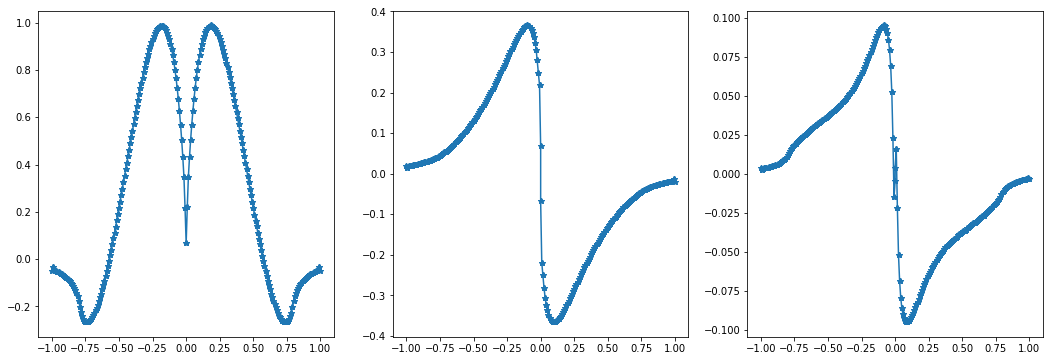

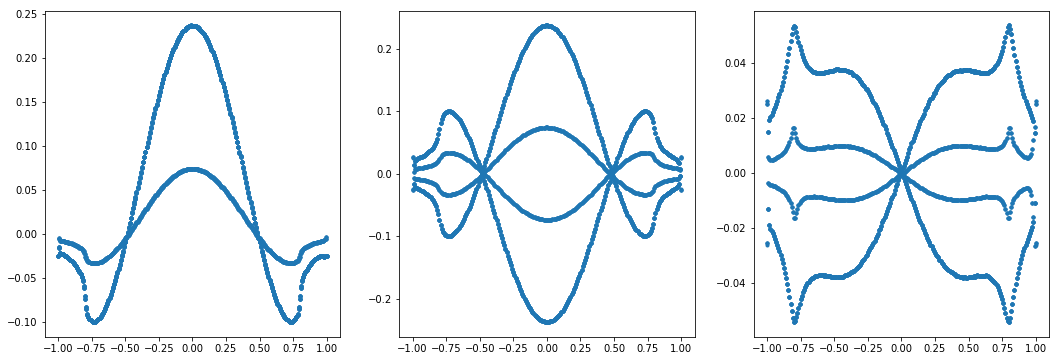

In [107]:
csT1, csT2 = tct.traction_admissibility_constraints(src_mesh[0], src_mesh[1], slip, 1.0, 0.25)
csT1.extend(edge_cs)
#csT1.extend(csT2)
cmT, c_rhs, _ = tct.build_constraint_matrix(csT1, src_mesh[1].shape[0] * 9)

import scipy.sparse
rows = []
cols = []
data = []
cmT2_rhs = np.zeros((len(csT2)))
for i in range(len(csT2)):
    c = csT2[i]
    for j in range(len(c.terms)):
        rows.append(i)
        cols.append(c.terms[j].dof)
        data.append(c.terms[j].val)
    cmT2_rhs[i] = c.rhs
cmT2 = scipy.sparse.csr_matrix((data, (rows, cols)), shape = (len(csT2), cmT.shape[0]))

constrained_traction_mass_op = cmU.T.dot(traction_mass_op.mat.dot(cmT))
full_lhs = scipy.sparse.vstack((constrained_traction_mass_op, cmT2.dot(cmT)))
rhs = -cmU.T.dot(H.dot(slip.flatten())) - cmU.T.dot(traction_mass_op.mat.dot(c_rhs))
full_rhs = np.concatenate((rhs, cmT2_rhs - cmT2.dot(c_rhs)))

# full_lhs.shape, full_rhs.shape, cmT.shape, cmU.shape, cmT2.shape, constrained_traction_mass_op.shape

#soln = cg(constrained_traction_mass_op, rhs)
soln = scipy.sparse.linalg.lsmr(full_lhs, full_rhs, show = True, atol = 1e-8)
out = cmT.dot(soln[0]) + c_rhs

pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,2] - 0.115) < 0.005)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.figure(figsize = (18, 6))
for d in range(3):
    plt.subplot(1,3,d+1)
    plt.plot(pts[idxs][:,0], out.reshape((-1,3))[idxs][:,d], '-*')
plt.show()
    
pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.figure(figsize = (18, 6))
for d in range(3):
    plt.subplot(1,3,d+1)
    plt.plot(pts[idxs][:,2], out.reshape((-1,3))[idxs][:,d], '.')
plt.show()

/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


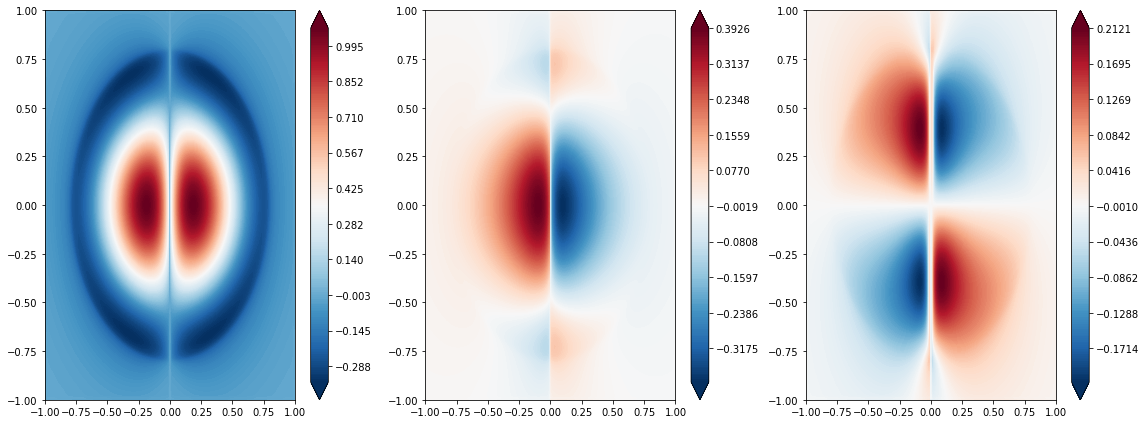

In [113]:
def plotter(fields):
    levels = []
    for f in fields:
        minf = np.min(f)
        maxf = np.max(f)
        levels.append(np.linspace(minf - 1e-12, maxf + 1e-12, 200))
    #levels[2] = np.linspace(-0.15, 0.15, 11)
    # levels = [
    #     np.linspace(-0.1, 0.6, 21),
    #     np.linspace(-1.9, 1.9, 21),
    #     np.linspace(-0.2, 0.2, 21)
    # ]
    tri_centers = np.mean(src_mesh[0][src_mesh[1]], axis = 1)
    side = np.zeros(src_mesh[1].shape[0]).astype(np.int)
    side[tri_centers[:,0] > 0] = 1
    n_sides = 2

    cmap = 'RdBu_r'
    plt.figure(figsize = (16, 6))
    for d in range(len(fields)):
        plt.subplot(1,len(fields),d+1)
        field = fields[d]
        for i in range(n_sides):
            which_tris = np.where(side == i)[0]
            reduced_m = tct.mesh.modify.remove_unused_pts((src_mesh[0], src_mesh[1][which_tris]))
            soln_vals = np.empty(reduced_m[0].shape[0])
            soln_vals[reduced_m[1]] = field[which_tris]
            cntf = plt.tricontourf(
                reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
                cmap = cmap, linewidth = 0.5, levels = levels[d], extend = 'both'
            )
            if levels[d].shape[0] < 25:
                plt.tricontour(
                    reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
                    linestyles = 'solid', colors='k', linewidths = 0.7, levels = levels[d]
                ) 
        plt.colorbar(cntf)
        plt.tight_layout()
    plt.show()
    
zvec = np.cross(ns, [0,1,0])
xvec = np.cross(zvec, ns)

normal_trac = np.sum(out.reshape((-1,3)) * ns, axis = 1).reshape((-1,3))
horizontal_shear = np.sum(out.reshape((-1,3)) * xvec, axis = 1).reshape((-1,3))
vertical_shear = np.sum(out.reshape((-1,3)) * zvec, axis = 1).reshape((-1,3))
    
# plotter([
#     horizontal_shear, 
#     normal_trac,
#     vertical_shear
# ])
plotter([
    out.reshape((-1,3,3))[:,:,d]
    for d in range(3)
])

In [99]:
cmT.shape, cmT2.shape, cmU.shape, cmT.shape[1] - cmT2.shape[0]

((1036800, 172080), (717, 1036800), (1036800, 171363), 171363)